# MSDS 7331 - Mini-Project 1
## Jeff Weltman, Kevin Dickens, Jordan Kassof
## June 10, 2018

<hr>

# Introduction

**Primer:** We are using the Belk North Carolina Education Dataset (available on Github here) to explore the factors involved when a school outperforms, on average, 

In Lab 1, we explored the relationships in our data using a wide range of st

This data set of North Carolina High Schools was generated by preprocessing steps undertaken both by the author as well as our team in Lab1 1. It therefore already contains our response variable, *sat_high_level*.  
If a High School's average SAT score met or exceeded 1080, the 66th percentile national average score, we classified that as *'high'* (Y=1). 

# Section 1: Create Models

**50	Create a logistic regression model and a support vector machine model for the classification task involved with your dataset. Assess how well each model performs (use 80/20 training/testing split for your data). Adjust parameters of the models to make them more accurate. If your dataset size requires the use of stochastic gradient descent, then linear kernel only is fine to use. That is, the SGDClassifier is fine to use for optimizing logistic regression and linear support vector machines. For many problems, SGD will be required in order to train the SVM model in a reasonable timeframe**

In this section, we'll use two classical data mining techniques to further our understanding of the relationships found in our data.

## Section 1A: Logistic Regression

We utilized scikit-learn's ShuffleSplit to produce training and testing subsets of our data, with 80% training data and 20% testing data. Next, we employed 10-fold cross-validation to ensure our model was generalized, rather than overfit. Lastly, we created a pipeline to scale the data and then perform the logistic regression for each step of a grid search in order to obtain the best set of model parameters. We measured the classifier's accuracy and scoring metrics using a function defined by Dr. Jake Drew, which will be publicly available on his [GitHub repo](https://github.com/jakemdrew/EducationDataNC) at a later date.

First, we import the pre-processed data file from our local GitHub repository.

In [2]:
%config IPCompleter.greedy=True
import numpy as np
import pandas as pd

# Read dataset off Github
hs_2017 = pd.read_csv("https://github.com/jeffweltman/MSDS7331/raw/master/hs_2017.csv",index_col=0)

Prior to splitting our data for prediction, we can utilize a count plot to show the distribution for our response variable, *sat_high_level*, as a comparison baseline.    
We can see that approximately one-third of the schools meet our predefined threshold, equating to 37.77% of objects having a value of 1 and the remaining 62.23% having a value of 0.

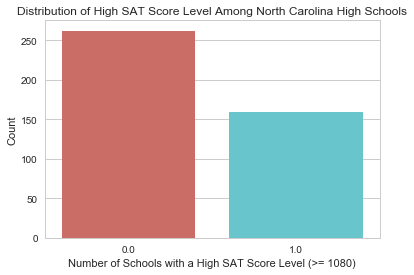

0.0    262
1.0    159
Name: sat_high_level, dtype: int64

In [8]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

sns.countplot(x='sat_high_level',data=hs_2017, palette='hls')
plt.xlabel('Number of Schools with a High SAT Score Level (>= 1080)')
plt.ylabel('Count')
plt.title('Distribution of High SAT Score Level Among North Carolina High Schools')
plt.show()
hs_2017['sat_high_level'].value_counts()

First, we establish the parameters for our logistic regression, setting X and Y as well as defining the train/test split.
As we are looking to classify whether or not a school meets or exceeds the threshold for a high SAT score, we will remove the SAT score columns to prevent collinearity.

In [9]:
Y=hs_2017['sat_high_level'].values
hs_2017=hs_2017.drop({'sat_high_level','sat_avg_score_num','lea_sat_avg_score_num'}, axis=1) 
X_highSchools=hs_2017

In [10]:
#Divide data into test and training splits
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=0)

Next, we define our accuracy and scoring metrics, using the aforementioned functions created by Dr. Drew.

In [11]:
from sklearn.model_selection import cross_validate

def EvaluateClassifierEstimator(classifierEstimator, X, y, cv):
   
    #Perform cross validation 
    scores = cross_validate(classifierEstimator, X_highSchools, Y, scoring=['accuracy','precision','recall']
                            , cv=cv, return_train_score=True)

    Accavg = scores['test_accuracy'].mean()
    Preavg = scores['test_precision'].mean()
    Recavg = scores['test_recall'].mean()

    print_str = "The average accuracy for all cv folds is: \t\t\t {Accavg:.5}"
    print_str2 = "The average precision for all cv folds is: \t\t\t {Preavg:.5}"
    print_str3 = "The average recall for all cv folds is: \t\t\t {Recavg:.5}"

    print(print_str.format(Accavg=Accavg))
    print(print_str2.format(Preavg=Preavg))
    print(print_str3.format(Recavg=Recavg))
    print('*********************************************************')

    print('Cross Validation Fold Mean Error Scores')
    scoresResults = pd.DataFrame()
    scoresResults['Accuracy'] = scores['test_accuracy']
    scoresResults['Precision'] = scores['test_precision']
    scoresResults['Recall'] = scores['test_recall']

    return scoresResults

def EvaluateClassifierEstimator2(classifierEstimator, X, y, cv):
    
    #Perform cross validation 
    from sklearn.model_selection import cross_val_predict
    predictions = cross_val_predict(classifierEstimator, X_highSchools, Y, cv=cv)
    
    #model evaluation 
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
    
    #pass true test set values and predictions to classification_report
    classReport = classification_report(Y,predictions)
    confMat = confusion_matrix(Y,predictions)
    acc = accuracy_score(Y,predictions)
    
    print(classReport)
    print(confMat)
    print(acc)


Now we create a pipeline to employ logistic regression through the steps of a grid search. 

Our final logistic regression model therefore meets these two criteria: 
1. The most optimally-calibrated regression is executed, due to the grid search;
2. The weights are easily interpretable, due to the standard scaling.

In [12]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit

#create a pipeline to scale all of the data and perform logistic regression during each grid search step.
pipe = make_pipeline(StandardScaler(), LogisticRegression())

# Define a range of hyper parameters for grid search
parameters = { 'logisticregression__penalty':['l2']
              ,'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
              ,'logisticregression__class_weight': ['balanced','none']
              ,'logisticregression__random_state': [0]
              ,'logisticregression__solver': ['lbfgs']
              ,'logisticregression__max_iter':[100,500]
             }

#Perform the grid search using accuracy as a metric during cross validation.
grid = GridSearchCV(pipe, parameters, cv=cv, scoring='accuracy')

#Use the best features from recursive feature elimination during the grid search
grid.fit(X_highSchools, Y)

#display the best pipeline model identified during the grid search
grid.best_estimator_

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=0.01, class_weight='none', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False))])

With our best model in hand, we can assess the performance first of each cross-validation fold.

In [13]:
EvaluateClassifierEstimator(grid.best_estimator_, X_highSchools, Y, cv)

The average accuracy for all cv folds is: 			 0.87176
The average precision for all cv folds is: 			 0.84947
The average recall for all cv folds is: 			 0.8107
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall
0,0.858824,0.866667,0.764706
1,0.858824,0.900000,0.750000
2,0.835294,0.815789,0.815789
3,0.823529,0.750000,0.818182
4,0.858824,0.807692,0.750000
5,0.882353,0.892857,0.781250
6,0.905882,0.903226,0.848485
7,0.917647,0.882353,0.909091
8,0.835294,0.812500,0.764706
9,0.941176,0.863636,0.904762


Lastly, we obtain the confusion matrix and the overall model metrics for precision, recall, f1-score, and support.

In [14]:
EvaluateClassifierEstimator2(grid.best_estimator_, X_highSchools, Y, 10)

             precision    recall  f1-score   support

        0.0       0.88      0.92      0.90       262
        1.0       0.85      0.79      0.82       159

avg / total       0.87      0.87      0.87       421

[[240  22]
 [ 34 125]]
0.8669833729216152


## Section 1B: Support Vector Machines

**Some Introductory commentary on logistic regression goes here **

In [7]:
# Place holder for code or markdown related to the 
# generation and optimization of a support vector machine

In [8]:
# Place holder for code or markdown related to the 
# generation and optimization of a support vector machine

In [9]:
# Place holder for code or markdown related to the 
# generation and optimization of a support vector machine

In [10]:
# Place holder for code or markdown related to the 
# generation and optimization of a support vector machine

In [11]:
# Place holder for code or markdown related to the 
# generation and optimization of a support vector machine

In [12]:
# Place holder for code or markdown related to the 
# generation and optimization of a support vector machine

# Section 2: Model Advantages

**Discuss the advantages of each model for each classification task. Does one type of model offer superior performance over another in terms of prediction accuracy? In terms of training time or efficiency? Explain in detail.**

In this section we will explore the nature of logistic regression and SVMs, including pros, cons, and other conisderations.

In [13]:
## Placeholder for code or markdwon related to compare & contrast of the two types of models

In [14]:
## Placeholder for code or markdwon related to compare & contrast of the two types of models

In [15]:
## Placeholder for code or markdwon related to compare & contrast of the two types of models

# Section 3: Interpret Feature Importance

**30	Use the weights from logistic regression to interpret the importance of different features for the classification task. Explain your interpretation in detail. Why do you think some variables are more important?** 

As explained in [*Guyon, et. al*](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.70.9598&rep=rep1&type=pdf), *"the inputs that are weighted by the largest value influence most the classification decision. Therefore, if the classifier performs well, those inputs with the largest weights correspond to the most informative features."* (p.6) 
  
We can determine which features contribute the most towards the classification by identifying those with the highest absolute weight. We thus begin interpretation by creating a data frame of the features and their weights from the the grid search's best estimator, sorting by the highest **absolute** weight in order to include both positively and negatively correlated attributes.

In [15]:
X_highSchools=pd.DataFrame(X_highSchools) # casting as dataframe for column interpretation

#Load the model's coefficient weights and feature names into a dataframe sorted by weights
weights = grid.best_estimator_.named_steps['logisticregression'].coef_.ravel()
feature_names = X_highSchools.columns.values #[rfecv.get_support(indices=True)]

linreg_ft_imp_df = pd.DataFrame({'feature_names':feature_names, 'weights':weights, 'absolute_weights': np.abs(weights)})
linreg_ft_imp_df.sort_values(by='absolute_weights', inplace=True, ascending=False )

Below we reverse the sort order to display the weights in descending order and then plot the 25 highest features.

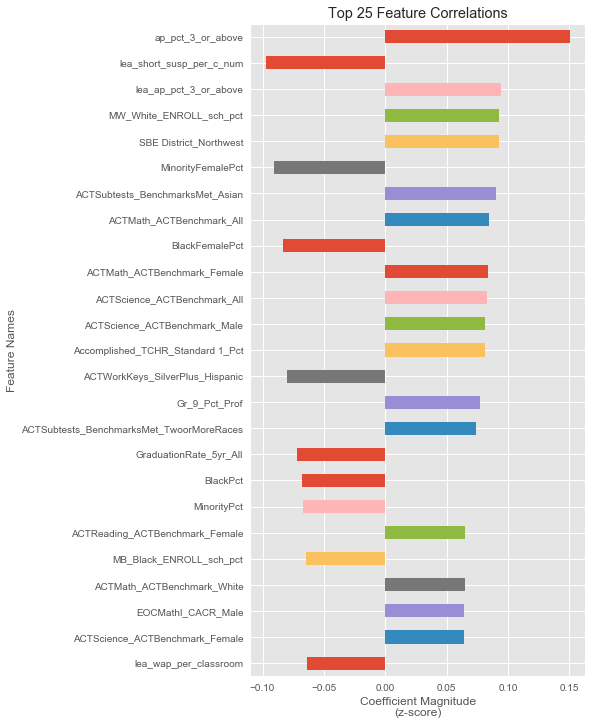

In [19]:
# Examine categorical variables of interest  
import matplotlib.pyplot as plt

%matplotlib inline

#Plot the model's feature importances
# REFERENCE:  Eric Larson, https://github.com/eclarson/DataMiningNotebooks
plt.style.use('ggplot')

wt_plt_df = linreg_ft_imp_df.head(25) # obtains the 75 most highly-weighted attributes
wt_plt_df = pd.DataFrame(wt_plt_df)
wt_plt_df.sort_values(by='absolute_weights', inplace=True, ascending=True) # reverses the sorting

weights = pd.Series(wt_plt_df['weights'].values,index=wt_plt_df['feature_names'])
ax = weights.plot(kind='barh', figsize=(6,12))

ax.set_title("Top 25 Feature Correlations")
ax.set_xlabel("Coefficient Magnitude\n(z-score)")
ax.set_ylabel("Feature Names")

plt.show()

### Interpreting the 10 Most Important Features

#### *ap_pct_3_or_above*
The most significant positively-correlated feature is *ap_pct_3_or_above*, which represents the percentage of students scoring a 3 or better on the AP Exam. As high scores on advanced placement exams are indicative of academic ability, we can see that this is positively associated with higher scores on the SAT. As a school's percentage of students scoring a 3 or better on the advanced placement exam increases, so does a school's average SAT score.

#### *lea_short_susp_per_c_num*
The second most informative feature, *lea_short_susp_per_c_num*, represents the number of short-term suspensions per 100 students at the district level. This is negatively correlated, indicating that a school's SAT score is expected to decrease as the number of short-term suspensions increases comparison to the district. A higher volume of suspension-level disciplinary actions both takes students out of the classroom and may coincide with an overall decrease in academic performance. Therefore, the evidence suggests a school's SAT score level will be lower as suspension volume is higher at the district level.  

#### *lea_ap_pct_3_or_above*
The third most informative feature, *lea_ap_pct_3_or_above*, similarly represents the aforementioned AP score at the district level. When comparing a particular school's AP Exam performance in relation to the other school's of the given district, this feature shows that the academic performance associated with higher advanced placement exam scores does lend itself towards increased SAT scores as well.

#### *MW_White_ENROLL_sch_pct*
This fourth most informative feature, *MW_White_ENROLL_sch_pct*, represents the school's percentage of white students enrolled. The postive correlation indicates that an increase in percentage of white enrolled students is positively associated with an increase in SAT score level. The implication here is that white enrolled students are expected to increase a school's average SAT score due to positively contributing high test scores on the SAT.

#### *SBE District_Northwest*
*SBE District_Northwest*, the fifth most informative feature, is the school's presence in the State Board of Education's Northwest district. This positive correlation suggests that schools which are in the Northwest SBE district are more likely to have a higher SAT score level than schools in other districts. Further evidence to support this lies in the acknowledgment that no other SBE district indicator is contained within these top-25 features. We could conclude that schools in this district typically produce high SAT scores, and indeed higher scores than schools in other districts in North Carolina.

#### *MinorityFemalePct*
*MinorityFemalePct*, the sixth most informative feature, is the school's percentage of minority female enrolled students. This feature is negatively correlated with SAT score level, which suggests that the likelihood of a school achieving a high SAT score level decreases when the percentage of minority female students increases. The implication here is that minority female students are not expected to perform well on the SAT, lowering the school's average SAT score.

#### *ACTSubtests_BenchmarksMet_Asian* 
The seventh most informative feature, *ACTSubtests_BenchmarksMet_Asian*, is the percent of asian students meeting the ACT subtest benchmark. The positive correlation indicates that a school is more likely to have a high SAT score level as the percentage of asian students meeting the ACT subtest benchmark increases. There are two implications here. First, as above, we can expect that meeting benchmarks on one standardized test lends itselfs towards higher scores on another standardized test. Secondly, as this attribute pertains to a specific demographic subset, the implication is that a school's asian population which meets the ACT subtest benchmarks is expected to increase the school's overall SAT score, which suggests that this population subset itself may also be likely to score well on the SAT.

#### *ACTMath_ACTBenchmark_All *
*ACTMath_ACTBenchmark_All*, the eighth most informative feature, is the percent of all students meeting the ACT math benchmark. As the SAT includes a Math component, it follows that meeting the ACT Math benchmark is positively associated with increased SAT scores. Although the two tests should not be expected to identically assess mathematical aptitude, the evidence suggests that success on the ACT Math portion lends itself towards a higher SAT score level in general.

#### *BlackFemalePct*
The ninth most informative feature, *BlackFemalePct*, is the percent of Black or African American females in the school's population. This negative correlation indicates that increasing the school's percentage of Black or African American females decreases the likelihood that a school's SAT score level will be high. This implies that Black or African American female students have lower than average SAT scores, which would account for the average decrease in a school's SAT score as this student population subset increases.

#### *ACTMath_ACTBenchmark_Female *
*ACTMath_ACTBenchmark_Female*, the tenth most informative feature, is the percent of female students meeting the ACT math benchmark. As the SAT includes a Math component, it follows that meeting the ACT Math benchmark is positively associated with increased SAT scores. Although the two tests should not be expected to identically assess mathematical aptitude, the evidence suggests that success on the ACT Math portion lends itself towards a higher SAT score level in general. As pertains to the specificity of this demographic subset, the implication is that a higher percentage of female students meeting the ACT Match benchmark will be associated with an increase in SAT level.


# Section 4: Interpret Feature Importance

**	10	Look at the chosen support vectors for the classification task. Do these provide any insight into the data? Explain. If you used stochastic gradient descent (and therefore did not explicitly solve for support vectors), try subsampling your data to train the SVC model— then analyze the support vectors from the subsampled dataset**

In [19]:
# Placeholder for code or markdown related to section 4

In [20]:
# Placeholder for code or markdown related to section 4

In [ ]:
# Placeholder for code or markdown related to section 4